# 🤖 MODELAGEM DE MACHINE LEARNING PARA SCORE DE CRÉDITO

**Objetivo:** Desenvolver, avaliar e selecionar modelos de Machine Learning para prever a inadimplência de clientes.

### 📌 Etapas
- Reparar dados para Machine Learning
- Codificar variáveis categóricas
- Dividir em treino e teste
- Treinar múltiplos modelos de classificação
- Avaliar performance com métricas adequadas
- Selecionar melhor modelo
- Analisar feature importance
- Salvar modelo para produção

### 🏆 Modelo que vamos testar
- Random Forest (Ensemble)
- KNN (K-Nearest Neighbors)
- Logistic Regression (Linear)
- Decision-Tree (Base do Random Forest)

In [33]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib  # Para salvar modelos
from datetime import datetime
import warnings
import os
warnings.filterwarnings('ignore')

# ML
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Métricas
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, ConfusionMatrixDisplay
)

# Configs de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")
%matplotlib inline

In [34]:
# Carregando dados do SQLite
DB_PATH = 'data/database.db'
print(f"\n📂 Carregando dados: {DB_PATH}")

conn = sqlite3.connect(DB_PATH)
df = pd.read_sql("SELECT * FROM clientes", conn)
conn.close()


📂 Carregando dados: data/database.db


In [35]:
# Codificando variáveis categóricas
print("🔄 CODIFICANDO VARIÁVEIS CATEGÓRICAS")

# Identifica
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
if 'inadimplente' in cat_cols:
  cat_cols.remove('inadimplente')

print(f"\n📝 Variáveis categóricas: {cat_cols}")

# Codifica e salva encoders
encoders = {}

os.makedirs('../models', exist_ok=True)

for col in cat_cols:
  encoder = LabelEncoder()
  df[col] = encoder.fit_transform(df[col])
  encoders[col] = encoder
    
  joblib.dump(encoder, f'../models/encoder_{col}.pkl')
  print(f"   ✅ {col}: {list(encoder.classes_)}")

print(f"\n💾 {len(encoders)} encoders salvos em ../models/")

🔄 CODIFICANDO VARIÁVEIS CATEGÓRICAS

📝 Variáveis categóricas: ['genero', 'estado_civil', 'escolaridade', 'estado', 'ocupacao']
   ✅ genero: ['F', 'M']
   ✅ estado_civil: ['Casado', 'Divorciado', 'Solteiro', 'Viúvo']
   ✅ escolaridade: ['Fundamental', 'Médio', 'Pós-graduação', 'Superior']
   ✅ estado: ['BA', 'CE', 'GO', 'MG', 'PE', 'PR', 'RJ', 'RS', 'SC', 'SP']
   ✅ ocupacao: ['Autônomo', 'CLT', 'Desempregado', 'Empresário']

💾 5 encoders salvos em ../models/


In [36]:
# Prepara X e Y
print("✂️ SEPARANDO FEATURES (X) E TARGET (y)")

# Remove ID (coluna desnecessária) e Target (Principal)
X = df.drop(columns=['id_cliente', 'inadimplente'])
y = df['inadimplente']

print(f"\n📊 X: {X.shape} - {X.shape[1]} features")
print(f"📊 y: {y.shape}")
print(f"\nFeatures: {list(X.columns)}")

✂️ SEPARANDO FEATURES (X) E TARGET (y)

📊 X: (100000, 15) - 15 features
📊 y: (100000,)

Features: ['idade', 'genero', 'estado_civil', 'escolaridade', 'estado', 'renda_anual', 'valor_patrimonio', 'possui_imovel_proprio', 'possui_carro', 'ocupacao', 'numero_dependentes', 'tempo_emprego_atual', 'score_serasa_externo', 'utilizacao_limite_cartao', 'historico_atraso_90_dias']


In [37]:
# Dividir Treino/Teste
print("🔀 TREINO/TESTE (70/30)")

X_train, X_test, y_train, y_test = train_test_split(
  X, y,
  test_size=0.3,
  random_state=42,
  stratify=y
)

print(f"\n✅ Treino: {len(X_train):,} ({len(X_train)/len(X)*100:.0f}%)")
print(f"✅ Teste:  {len(X_test):,} ({len(X_test)/len(X)*100:.0f}%)")
print(f"\nTaxa inadimplência treino: {y_train.mean()*100:.2f}%")
print(f"Taxa inadimplência teste:  {y_test.mean()*100:.2f}%")

🔀 TREINO/TESTE (70/30)

✅ Treino: 70,000 (70%)
✅ Teste:  30,000 (30%)

Taxa inadimplência treino: 19.20%
Taxa inadimplência teste:  19.20%


In [38]:
# Normalização (Para KNN e LR)
print("⚖️ NORMALIZAÇÃO (StandardScaler)")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Converte de volta para DataFrame
X_train_scaled = pd.DataFrame(
  X_train_scaled,
  columns=X.columns,
  index=X_train.index
)

X_test_scaled = pd.DataFrame(
  X_test_scaled,
  columns=X.columns,
  index=X_test.index
)

print("✅ Dados normalizados (média=0, std=1)")
joblib.dump(scaler, '../models/scaler.pkl')
print("💾 Scaler salvo em ../models/scaler.pkl")

⚖️ NORMALIZAÇÃO (StandardScaler)
✅ Dados normalizados (média=0, std=1)
💾 Scaler salvo em ../models/scaler.pkl


In [39]:
# Treinar Modelos
print("🤖 TREINANDO MODELOS")

modelos = {}

# ──────────────────────────────────────────────────────────────────────────
# RANDOM FOREST
# ──────────────────────────────────────────────────────────────────────────
print("\n1️⃣ Random Forest...")
modelo_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # IMPORTANTE: lida com desbalanceamento
)
modelo_rf.fit(X_train, y_train)
modelos['Random Forest'] = modelo_rf
print("✅ Treinado (SEM normalização)")


# ──────────────────────────────────────────────────────────────────────────
# LOGISTIC REGRESSION
# ──────────────────────────────────────────────────────────────────────────
print("\n2️⃣ Logistic Regression...")
modelo_lr = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
modelo_lr.fit(X_train, y_train)
modelos['Logistic Regression'] = modelo_lr
print("✅ Treinado (COM normalização)")


# ──────────────────────────────────────────────────────────────────────────
# KNN (K-Nearest Neighbors)
# ──────────────────────────────────────────────────────────────────────────
print("\n3️⃣ KNN...")
modelo_knn = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',
    n_jobs=-1
)
modelo_knn.fit(X_train_scaled, y_train)
modelos['KNN'] = modelo_knn
print("✅ Treinado (COM normalização)")


🤖 TREINANDO MODELOS

1️⃣ Random Forest...
✅ Treinado (SEM normalização)

2️⃣ Logistic Regression...
✅ Treinado (COM normalização)

3️⃣ KNN...
✅ Treinado (COM normalização)


In [42]:
# Previsões
print("🔮 FAZENDO PREVISÕES")

previsoes = {}
probabilidades = {}

# RF (sem normalização)
previsoes['Random Forest'] = modelo_rf.predict(X_test)
probabilidades['Random Forest'] = modelo_rf.predict_proba(X_test)[:, 1]

# LR (com normalização)
previsoes['Logistic Regression'] = modelo_lr.predict(X_test_scaled)
probabilidades['Logistic Regression'] = modelo_lr.predict_proba(X_test_scaled)[:, 1]

# KNN (com normalização)
previsoes['KNN'] = modelo_knn.predict(X_test_scaled)
probabilidades['KNN'] = modelo_knn.predict_proba(X_test_scaled)[:, 1]

🔮 FAZENDO PREVISÕES


In [ ]:
# Avaliar Modelos - MÉTRICAS COMPLETAS
print("📊 AVALIAÇÃO DOS MODELOS")

"""
IMPORTANTE: Em crédito, RECALL é mais importante que ACCURACY!

Por quê?
- Accuracy alta pode ser enganosa (prevê tudo como adimplente)
- RECALL mede: "dos inadimplentes reais, quantos detectamos?"
- Em crédito, NÃO detectar inadimplente é mais caro!

Métricas priorizadas:
1. Recall (classe inadimplente)
2. AUC-ROC (performance geral)
3. F1-Score (balanço)
"""

resultados = {}

for nome in modelos.keys():
      y_pred = previsoes[nome]
      y_prob = probabilidades[nome]
    
      # Calcula métricas
      acc = accuracy_score(y_test, y_pred)
      prec = precision_score(y_test, y_pred)
      rec = recall_score(y_test, y_pred)  # ← MÉTRICA PRINCIPAL
      f1 = f1_score(y_test, y_pred)
      auc = roc_auc_score(y_test, y_prob)
    
      resultados[nome] = {
          'Accuracy': acc,
          'Precision': prec,
          'Recall': rec,  # ← PRIORIDADE
          'F1-Score': f1,
          'AUC-ROC': auc  # ← MUITO IMPORTANTE EM CRÉDITO
      }
    
      print(f"\n{'═'*80}")
      print(f"📌 {nome}")
      print(f"{'═'*80}")
      print(f"   Accuracy:  {acc:.4f} ({acc*100:.2f}%)")
      print(f"   Precision: {prec:.4f} ({prec*100:.2f}%)")
      print(f"   Recall:    {rec:.4f} ({rec*100:.2f}%) ⭐ PRINCIPAL")
      print(f"   F1-Score:  {f1:.4f} ({f1*100:.2f}%)")
      print(f"   AUC-ROC:   {auc:.4f} ({auc*100:.2f}%) ⭐ IMPORTANTE")
    
      print(f"\n💡 Interpretação:")
      print(f"• Detecta {rec*100:.0f}% dos inadimplentes reais")
      print(f"• Quando aprova, {prec*100:.0f}% são confiáveis")


📊 AVALIAÇÃO DOS MODELOS

════════════════════════════════════════════════════════════════════════════════
📌 Random Forest
════════════════════════════════════════════════════════════════════════════════
   Accuracy:  0.8130 (81.30%)
   Precision: 0.5114 (51.14%)
   Recall:    0.5843 (58.43%) ⭐ PRINCIPAL
   F1-Score:  0.5454 (54.54%)
   AUC-ROC:   0.8524 (85.24%) ⭐ IMPORTANTE

💡 Interpretação:
• Detecta 58% dos inadimplentes reais
• Quando aprova, 51% são confiáveis

════════════════════════════════════════════════════════════════════════════════
📌 Logistic Regression
════════════════════════════════════════════════════════════════════════════════
   Accuracy:  0.6001 (60.01%)
   Precision: 0.2765 (27.65%)
   Recall:    0.6695 (66.95%) ⭐ PRINCIPAL
   F1-Score:  0.3913 (39.13%)
   AUC-ROC:   0.6668 (66.68%) ⭐ IMPORTANTE

💡 Interpretação:
• Detecta 67% dos inadimplentes reais
• Quando aprova, 28% são confiáveis

═════════════════════════════════════════════════════════════════════════════

🏆 SELEÇÃO DO MELHOR MODELO

                     Accuracy  Precision    Recall  F1-Score   AUC-ROC
Logistic Regression  0.600067   0.276468  0.669502  0.391335  0.666824
Random Forest        0.812967   0.511395  0.584274  0.545410  0.852437
KNN                  0.804733   0.482408  0.230863  0.312280  0.711922

🏆 MELHOR MODELO: Logistic Regression
Recall: 0.6695 (66.95%)
AUC-ROC: 0.6668 (66.68%)

💡 Escolhido por RECALL (detectar inadimplentes é prioridade!)


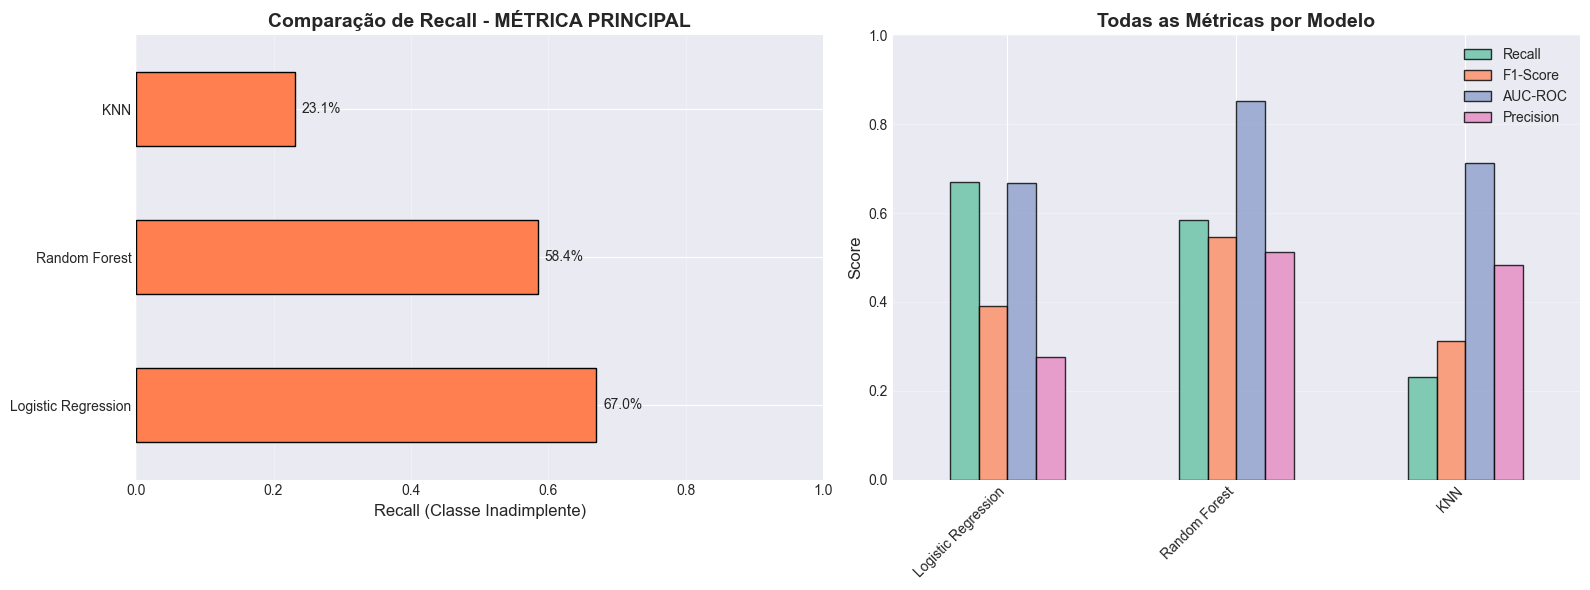

In [53]:
# Melhor Modelo (POR RECALL)
print("🏆 SELEÇÃO DO MELHOR MODELO")

df_resultados = pd.DataFrame(resultados).T

# ORDENA POR RECALL
df_resultados = df_resultados.sort_values('Recall', ascending=False)

print(f"\n{df_resultados.to_string()}")

# Melhor modelo
melhor_modelo = df_resultados.index[0]
melhor_recall = df_resultados.iloc[0]['Recall']
melhor_auc = df_resultados.iloc[0]['AUC-ROC']

print(f"\n🏆 MELHOR MODELO: {melhor_modelo}")
print(f"Recall: {melhor_recall:.4f} ({melhor_recall*100:.2f}%)")
print(f"AUC-ROC: {melhor_auc:.4f} ({melhor_auc*100:.2f}%)")
print(f"\n💡 Escolhido por RECALL (detectar inadimplentes é prioridade!)")

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Comparação de Recall
df_resultados['Recall'].plot(
    kind='barh', ax=axes[0], color='coral', edgecolor='black'
)
axes[0].set_xlabel('Recall (Classe Inadimplente)', fontsize=12)
axes[0].set_title('Comparação de Recall - MÉTRICA PRINCIPAL', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].set_xlim([0, 1])

for i, v in enumerate(df_resultados['Recall']):
    axes[0].text(v + 0.01, i, f'{v:.1%}', va='center')


# Todas as métricas
df_resultados[['Recall', 'F1-Score', 'AUC-ROC', 'Precision']].plot(
    kind='bar', ax=axes[1], alpha=0.8, edgecolor='black'
)
axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('Todas as Métricas por Modelo', fontsize=14, fontweight='bold')
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)
axes[1].legend(loc='upper right')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

📈 CURVA ROC E AUC 👇


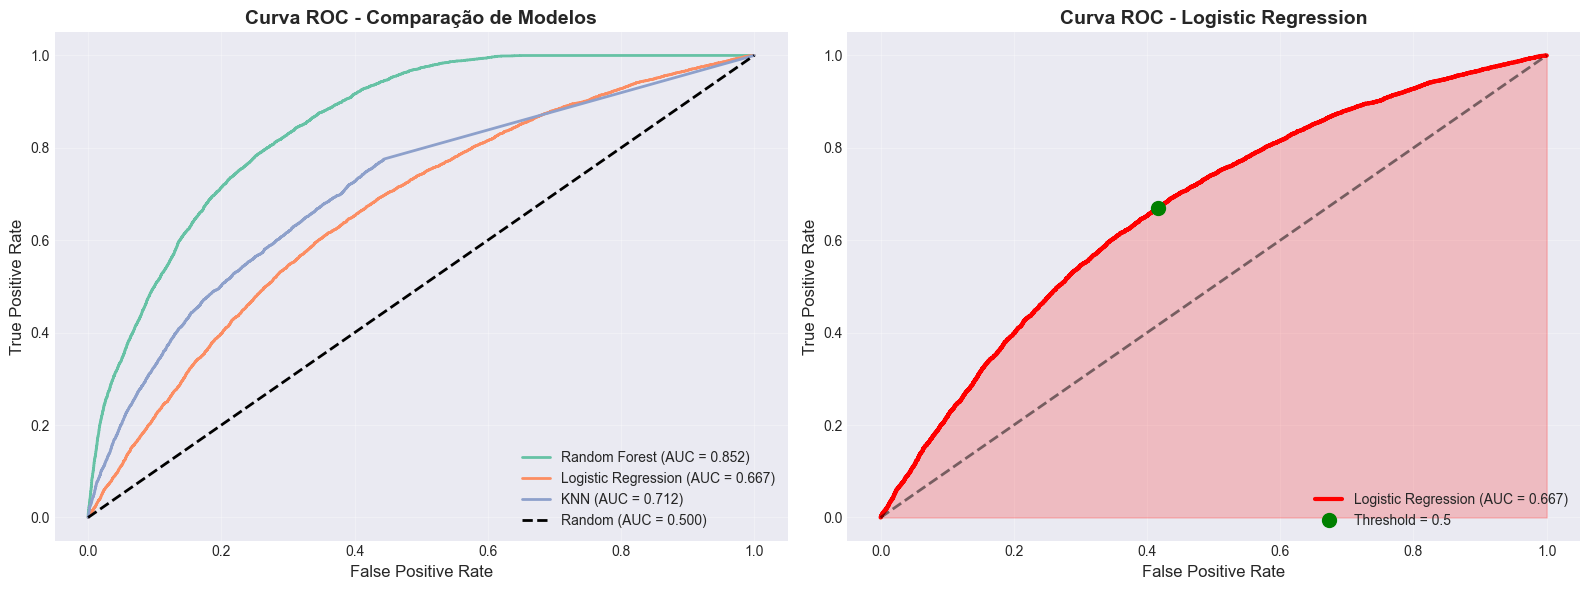


📊 AUC (Area Under Curve):
   Random Forest            : 0.8524 🟢 EXCELENTE
   Logistic Regression      : 0.6668 🟠 ACEITÁVEL
   KNN                      : 0.7119 🟡 BOM


In [ ]:
# Curva ROC e AUC (OBRIGATÓRIO EM CRÉDITO!)
print("📈 CURVA ROC E AUC 👇")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

"""
ROC (Receiver Operating Characteristic):
- Mostra trade-off entre True Positive Rate e False Positive Rate
- AUC (Area Under Curve): resumo em um número (0.5 a 1.0)
- AUC > 0.8: Excelente
- AUC > 0.7: Bom
- AUC > 0.6: Aceitável
- AUC = 0.5: Random (inútil)

Vantagem: independe do threshold!
"""


# ──────────────────────────────────────────────────────────────────────────
# ROC de todos os modelos
# ──────────────────────────────────────────────────────────────────────────
for nome in modelos.keys():
    y_prob = probabilidades[nome]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = resultados[nome]['AUC-ROC']
    
    axes[0].plot(fpr, tpr, linewidth=2, 
                label=f'{nome} (AUC = {auc:.3f})')
    
# Random
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random (AUC = 0.500)')

axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('Curva ROC - Comparação de Modelos', 
                 fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right')
axes[0].grid(alpha=0.3)


# ──────────────────────────────────────────────────────────────────────────
# ROC do MELHOR modelo (detalhado)
# ──────────────────────────────────────────────────────────────────────────
y_prob_best = probabilidades[melhor_modelo]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_best)
auc_best = resultados[melhor_modelo]['AUC-ROC']

axes[1].plot(fpr, tpr, linewidth=3, color='red', 
            label=f'{melhor_modelo} (AUC = {auc_best:.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.5)
axes[1].fill_between(fpr, tpr, alpha=0.2, color='red')

axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title(f'Curva ROC - {melhor_modelo}', 
                 fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(alpha=0.3)

# Adiciona ponto do threshold 0.5
idx_05 = np.argmin(np.abs(thresholds - 0.5))
axes[1].plot(fpr[idx_05], tpr[idx_05], 'go', markersize=10, 
            label=f'Threshold = 0.5')
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

print(f"\n📊 AUC (Area Under Curve):")
for nome, res in resultados.items():
    auc = res['AUC-ROC']
    if auc > 0.8:
        nivel = "🟢 EXCELENTE"
    elif auc > 0.7:
        nivel = "🟡 BOM"
    elif auc > 0.6:
        nivel = "🟠 ACEITÁVEL"
    else:
        nivel = "🔴 FRACO"
    print(f"{nome:25s}: {auc:.4f} {nivel}")

In [ ]:
# Análise de Threshold
print("🎚️ ANÁLISE DE THRESHOLD (DECISÃO DE NEGÓCIO)")

"""
THRESHOLD = ponto de corte para classificar

Threshold 0.5 (padrão):
- Se prob > 0.5 → Inadimplente
- Se prob ≤ 0.5 → Adimplente

MAS em crédito, threshold é DECISÃO DE NEGÓCIO!

Threshold BAIXO (0.3):
✅ Aprova mais clientes
✅ Mais receita
❌ Mais risco

Threshold ALTO (0.7):
✅ Menos risco
✅ Mais precision
❌ Aprova menos (perde clientes bons)
"""

# Testa diferentes thresholds
thresholds_teste = [0.3, 0.4, 0.5, 0.6, 0.7]
y_prob_best = probabilidades[melhor_modelo]

resultados_threshold = []

for threshold in thresholds_teste:
    # Aplica threshold
    y_pred_custom = (y_prob_best >= threshold).astype(int)
    
    # Calcula métricas
    prec = precision_score(y_test, y_pred_custom)
    rec = recall_score(y_test, y_pred_custom)
    f1 = f1_score(y_test, y_pred_custom)
    
    # Simula aprovação
    taxa_aprovacao = (y_pred_custom == 0).mean() * 100
    
    resultados_threshold.append({
        'Threshold': threshold,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'Taxa Aprovação': taxa_aprovacao
    })

df_threshold = pd.DataFrame(resultados_threshold)
print(f"\n{df_threshold.to_string(index=False)}")

print(f"\n💡 Interpretação:")
print(f"• Threshold 0.3: Aprova mais ({df_threshold.iloc[0]['Taxa Aprovação']:.1f}%), mas mais risco")
print(f"• Threshold 0.5: Balanço padrão ({df_threshold.iloc[2]['Taxa Aprovação']:.1f}%)")
print(f"• Threshold 0.7: Mais conservador ({df_threshold.iloc[4]['Taxa Aprovação']:.1f}%), menos risco")